# Overview
I am very pleased to see you here. This notebook is dedicated to the digit recognition. I will use both ML model and Neural Networks. A lot of attention will be paid to visualization and understanding of the process. Hope you enjoy!

# Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Convolution2D, MaxPooling2D, BatchNormalization

# Loading Data

In [ ]:
data_train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

### Checking the data

In [ ]:
print('Number of non-valid elements in training set:', data_train[data_train.isna() == True].count().sum(),
      '\nNumber of non valid elements in test set:', data_test[data_test.isna() == True].count().sum())

In [ ]:
data_train_pd = data_train.copy()

In [ ]:
true_labels = data_train.label
data_train = data_train.drop('label', axis = 1)

In [ ]:
data_train = data_train.values.reshape(-1, 28, 28, 1)
data_test = data_test.values.reshape(-1, 28, 28, 1)

# Quick visualization

## Label distribution

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x = true_labels, palette = 'rocket')
plt.show()

Classes of digits seem to be well-balanced, so we have to train the great classifier to solve the problem

## Visualizing the dataset
### Training set
Let's visualize some images!

In [ ]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 26, 1):
    plt.subplot(5, 5, i)
    plt.imshow(data_train[i])

### Test set

In [ ]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 26, 1):
    plt.subplot(5, 5, i)
    plt.imshow(data_test[i])

# T-SNE Dimensionality reduction
### The main idea of t-SNE algorythm
We have a data with points, but its dimensionality is much larger than 3 (which is possible to visualise). We need to get a new variable which can save the structure of the data. SNE transforms distance between points into probabilities that shows the similarity of the points

##### Taking a 1/4 of the data to visualize

In [ ]:
sample = data_train_pd.sample(n=10000, random_state=17)

### Using the algorythm implemented in sklearn

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
data_train_embedded = tsne.fit_transform(sample.drop('label', axis = 1))

#### Visualizing the results

In [ ]:
plt.figure(figsize=(10, 10))
plt.xlabel("new variable 1")
plt.title("Digits in reducted space")
plt.ylabel("new variable 2")
sns.scatterplot(x = data_train_embedded[:,0], y=data_train_embedded[:,1], hue=sample.label,legend=True, palette='bright')
plt.show()

After visualizing the results of t-Sne we can obtain some interesting results. Some digits (for example 0, 1 and 6) form visible clusters. It is also possible to understand, why digits 9 and 4 are now mixed.

# k-Nearest Neighbours

### I'll try to predict the digits using only kNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

X_train, X_holdout, y_train, y_holdout = train_test_split(data_train_pd.drop('label', axis = 1), data_train_pd.label, 
                                                     test_size = 0.25, random_state=0)
knn = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
knn.fit(X_train, y_train)


In [ ]:
#predictions = knn.predict(X_holdout)
#%time

After some time of predicting i found out that kNN is very SLOW

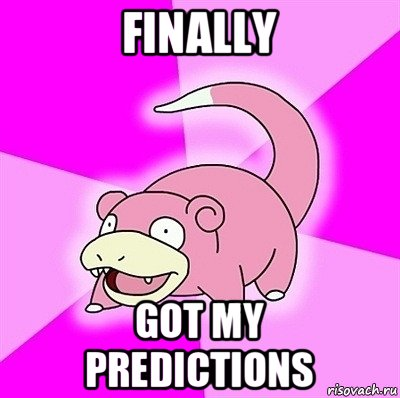

# Naive-Bayes Classification

#### Establishing base model

In [ ]:
from sklearn.naive_bayes import BernoulliNB

X_train, X_holdout, y_train, y_holdout = train_test_split(data_train_pd.drop('label', axis = 1), data_train_pd.label, 
                                                     test_size = 0.25, random_state=0)
bnbclf = BernoulliNB()
bnbclf.fit(X_train, y_train)

In [ ]:
print("Accuracy score: {:.2f}".format(bnbclf.score(X_holdout, y_holdout)))
print("Cross-entropy loss: {:.2f}".format(log_loss(np.array(y_holdout), bnbclf.predict_proba(X_holdout))))

### Visualizing the errors

In [ ]:
result = pd.DataFrame({'true_label' : y_holdout, 'predicted' : bnbclf.predict(X_holdout)})
errors = result[result.true_label != result.predicted]

plt.figure(figsize=(10,5))
sns.countplot(x = errors.true_label, palette = 'rocket')
plt.show()

In [ ]:
plt.figure(figsize=(11,9))
plt.title('Wrongly classified digits')
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(pd.crosstab(errors['true_label'], errors['predicted']).reset_index().drop('true_label', axis = 1), annot=True, fmt="d", cmap = cmap)
plt.show()

#### Tuning model

In [ ]:
from sklearn.model_selection import GridSearchCV
bnb_params = {'alpha':      np.arange(0.01, 0.1, 0.05),
              'binarize' :  np.arange(0, 0.5, 0.2),
              'fit_prior':  [True, False]
             }
bnbcv = GridSearchCV(bnbclf, param_grid = bnb_params, cv = 3)

In [ ]:
bnbcv.fit(X_train, y_train)
bnb_best = bnbcv.best_estimator_

In [ ]:
bnbcv.best_params_

In [ ]:
print("Accuracy score: {:.2f}".format(bnb_best.score(X_holdout, y_holdout)))
print("Cross-entropy loss: {:.2f}".format(log_loss(np.array(y_holdout), bnb_best.predict_proba(X_holdout))))

As we can see, tuning did not lead to great results

# Neural Network
First of all: "why Neural Network?". The answer is that NN is much more *non-linear* than standart algorythms.
It means, that it can resolve some extraordinal dependencies of an object.
#### Useful resource
[Here](https://playground.tensorflow.org/#activation=tanh&regularization=L2&batchSize=10&dataset=spiral&regDataset=reg-gauss&learningRate=0.3&regularizationRate=0&noise=0&networkShape=8,6,5&seed=0.23031&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=regression&initZero=false&hideText=false&batchSize_hide=false) you can play with neural networks in classification and regression problems. It is the great resource that allows you to create a NN and see how it *learns*

# Convolutional Neural Network
When it comes to image classification, we face the problem, that number of input features is very big. Even for this dataset, the standart input is 28x28 = 784. It is the number of neurons that you have to place in the input layer. This can affect perfomance. Convolutional Neural Networks (CNN) solve this problem by reducing the number of thainable parameters using filters (or kernels)
![im1](https://i.stack.imgur.com/Z0tNA.png)
## Useful resources
[Resource](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) to understand CNN

[Here](https://www.cs.ryerson.ca/~aharley/vis/conv/) you can play with digit regognizer in see CNN from the inside

[Here](https://poloclub.github.io/cnn-explainer/) you can understand image recognition via CNN

## Setting an architecture
Our model consists of group of convolution layers, which are needed to extract some image features. Here I use BatchNormalization in order to scale the outputs of MaxPooling layers. After all, outputs of convolution go to fully connected layers, which end up with Softmax. I have chosen softmax because it is great for classification problems.

In [ ]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization( axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer="zeros", gamma_initializer="ones",))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization( axis=1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer="zeros", gamma_initializer="ones",))


model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

## Scaling the data
Neural network is very sensitive to numbers, which are larger than 1. Large unscaled numbers can dramatically affect the perfomance and influence the stability of the optimization 

In [ ]:
data_train = data_train / 255
data_test = data_test / 255

In [ ]:
y = np.array(pd.get_dummies(true_labels))

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(data_train, y, 
                                                     test_size = 0.25, random_state=17)

## Model Training
Here is the finction, that can reduce learning rate in order to smoothen learning process

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.1,
                                                 patience=5,
                                                 min_lr=0.000001,
                                                 verbose=1)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
result = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_holdout, y_holdout), callbacks = [reduce_lr])

What we got here? We got the great improvement in quality!

# Visualizing the results

### Learning curve
Неre it is possible to see the progress of learning.

In [ ]:
plt.figure(figsize=(10, 9))
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'holdout'], loc='upper left')
plt.show()

### Visualizing the filters
We have a chance to see what our model learned to see. In the graphs below you may see some abstract features extracted from images. For example, it can be some horizontal or vertical lines detection.

In [ ]:
filters , bias = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 8
ix=1
fig = plt.figure(figsize=(20,40))
for i in range(n_filters):

    plt.subplot(n_filters,4,ix)
    plt.imshow(filters[:,:,:,i] ,cmap='gray', aspect='auto')
    ix+=1
#plot the filters 
plt.show()

### Visualizing feature maps
Let's explore, what happens to an image inside the network. Here you can see the transformation of the image when it passes the layer.

In [ ]:
from tensorflow.keras.models import Model
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
layer_outputs = [layer_outputs[0], layer_outputs[2]]
feature_map_model = Model(model.input, layer_outputs)
im = X_train[99:100,:]
feature_maps = feature_map_model.predict(im)

In [ ]:
for i in range(2):
    ix = 1
    plt.figure(figsize=(20,9))
    for j in range(feature_maps[i].shape[3]):
        im = feature_maps[i]
        
        ax = plt.subplot(4, 8, ix)
        ax.set_xticks([])

       
        ax.set_yticks([])
    # plot filter channel in grayscale
        plt.imshow(im[0,:,:,j])
        ix += 1
# show the figure
    plt.show()

# Improving the model
## Augumentation
What can we do, to improve the score? Of course we need to feed the model with more data! But where can we take this data? Let's just create it.
What I am going to do is to take a picture and do some random stuff with it. For example, rotate a bit, or zoom a little. By practice, augumentation can help our model not to overfit.

In [ ]:
augumentator =  tf.keras.preprocessing.image.ImageDataGenerator(   
    rotation_range=15,
    width_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.0,
    horizontal_flip=False,
    vertical_flip=False)

augumentator.fit(X_train)

## Visualize an augumented images

In [ ]:
fig.suptitle("Title centered above all subplots", fontsize=14)
for _ in range(5):
    ind = np.random.randint(10000)
    im = X_train[ind:ind+1,:][0]
    
    plt.subplot(1, 2, 1)
    plt.imshow(im)
    plt.subplot(1, 2, 2)
    plt.imshow(augumentator.random_transform(im))
    plt.show()

## Training on augumented dataset

In [ ]:
history = model.fit(augumentator.flow(X_train, y_train, batch_size = 32), epochs = 10, 
         validation_data = (X_holdout, y_holdout), verbose = 1, callbacks = [reduce_lr])

# Extending the data
A great idea is to exdend our training data. I hope it can influence quality of recognition

In [ ]:
mnist = tf.keras.datasets.mnist
(X_train_mnist, y_train_mnist), (X_val_mnist, y_val_mnist) = mnist.load_data()

In [ ]:
y_train_mnist = np.array(pd.get_dummies(pd.Series(y_train_mnist)))
y_holdout_mnist = np.array(pd.get_dummies(pd.Series(y_val_mnist)))

In [ ]:
X_train_mnist = X_train_mnist.reshape(-1, 28, 28, 1)
X_holdout_mnist = X_val_mnist.reshape(-1, 28, 28, 1)
X_train_mnist = X_train_mnist / 255
X_holdout_mnist = X_holdout_mnist /255

In [ ]:
X_train_ext = np.concatenate((X_train, X_train_mnist), axis = 0)
X_holdout_ext = np.concatenate((X_holdout, X_holdout_mnist), axis = 0)
y_train_ext = np.concatenate((y_train, y_train_mnist), axis = 0)
y_holdout_ext = np.concatenate((y_holdout, y_holdout_mnist), axis = 0)

In [ ]:
model.fit(X_train_ext, y_train_ext, batch_size=32, epochs=20, verbose=1, validation_data=(X_holdout, y_holdout), callbacks = [reduce_lr])

In [ ]:
predictions = model.predict(data_test).argmax(axis = 1)
predictions
submission = pd.DataFrame({'ImageId':np.arange(1, len(predictions)+1), 'Label':predictions})
submission.to_csv('submission.csv', index=False)